# 2.2 Pregled lastnosti molekulskih prstnih odtisov

In [1]:
%run __A_knjiznice.py

from __A_knjiznice import *
from __B_funkcije import *
import __C_konstante as kon
%matplotlib inline

In [2]:
input_directory = f'{kon.path_files}/molekulski_prstni_odtisi'

generated_fingerprints = ['df_standard.csv', 'df_extended.csv', 'df_graph.csv', 'df_maccs.csv', 'df_pubchem.csv', 
 'df_estate.csv', 'df_hybridization.csv', 'df_lingo.csv', 'df_klekota-roth.csv', 'df_shortestpath.csv', 
 'df_cdk-substructure.csv', 'df_circular.csv', 'df_cdk-atompairs.csv', 'df_rdkit.csv', 'df_morgan.csv', 
 'df_rdk-maccs.csv', 'df_topological-torsion.csv', 'df_avalon.csv', 'df_atom-pair.csv', 'df_fp2.csv']

In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, mutual_info_classif, chi2
from sklearn.impute import SimpleImputer

# Store summarized results in a list for easy comparison
summary_results = []

# List of percentage-based k values (as fractions of the total number of features)
top_k_percentages = [0.1, 0.25, 0.5, 0.6, 0.75, 0.9]  # 10%, 25%, 50%, 75%, 90%

# Loop through each fingerprint dataset
for filename in generated_fingerprints:
    file_path = os.path.join(input_directory, filename)
    
    if os.path.exists(file_path):
        print(f'Processing fingerprint DataFrame: {filename}')
        
        # Read the dataset
        df = pd.read_csv(file_path)
        fingerprint_name = filename.split('df_')[1].split('.')[0]
        X = df.iloc[:, 3:]  # Assuming features start from the 4th column
        y = df['Activity'].values.ravel()  # Flattening to 1D array if necessary
        
        # 1. Handle missing values: Impute missing values using the median (or other strategies)
        imputer = SimpleImputer(strategy='median')
        X_imputed = imputer.fit_transform(X)
        
        # 2. Remove features with low variance using VarianceThreshold
        variance_selector = VarianceThreshold(threshold=0.01)  # You can adjust the threshold
        X_high_variance = variance_selector.fit_transform(X_imputed)
        
        # 3. **ANOVA (f_classif)**: Apply SelectKBest with f_classif (ANOVA) to identify relevant features
        selector_anova = SelectKBest(score_func=f_classif, k='all')  # Get all features' scores
        selector_anova.fit(X_high_variance, y)
        anova_scores = selector_anova.scores_
        
        # Handle NaN in ANOVA scores (set them to zero if needed)
        anova_scores = np.nan_to_num(anova_scores)
        
        # 4. **Mutual Information (mutual_info_classif)**: Apply SelectKBest with mutual_info_classif
        selector_mi = SelectKBest(score_func=mutual_info_classif, k='all')
        selector_mi.fit(X_high_variance, y)
        mutual_info_scores = selector_mi.scores_
        
        # Handle NaN in Mutual Information scores (set them to zero if needed)
        mutual_info_scores = np.nan_to_num(mutual_info_scores)
        
        # 5. **Chi-Square (chi2)**: Apply SelectKBest with chi2
        selector_chi2 = SelectKBest(score_func=chi2, k='all')
        selector_chi2.fit(X_high_variance, y)
        chi2_scores = selector_chi2.scores_
        
        # Handle NaN in Chi-Square scores (set them to zero if needed)
        chi2_scores = np.nan_to_num(chi2_scores)
        
        # Get the total sum of scores for ANOVA, Mutual Information, and Chi-Square
        total_anova_score = np.sum(anova_scores)
        total_mi_score = np.sum(mutual_info_scores)
        total_chi2_score = np.sum(chi2_scores)
        
        # Loop over the percentage-based top k values and compute the percentage contribution to the total score
        for percentage in top_k_percentages:
            # Calculate the number of top features based on the percentage of the total number of features
            k = int(percentage * len(anova_scores))
            
            # Select top k features based on ANOVA score
            top_k_anova_features = np.argsort(anova_scores)[-k:]
            sum_anova_scores = np.sum(anova_scores[top_k_anova_features])
            
            # Select top k features based on Mutual Information score
            top_k_mi_features = np.argsort(mutual_info_scores)[-k:]
            sum_mi_scores = np.sum(mutual_info_scores[top_k_mi_features])
            
            # Select top k features based on Chi-Square score
            top_k_chi2_features = np.argsort(chi2_scores)[-k:]
            sum_chi2_scores = np.sum(chi2_scores[top_k_chi2_features])
            
            # Compute the proportional contribution of the top k features to the total score
            anova_contribution = (sum_anova_scores / total_anova_score) * 100
            mi_contribution = (sum_mi_scores / total_mi_score) * 100
            chi2_contribution = (sum_chi2_scores / total_chi2_score) * 100
            
            # Store the summarized metrics
            summary_results.append({
                'Fingerprint': fingerprint_name,
                'Top_k_Percentage': percentage * 100,  # Convert to percentage
                'ANOVA_Contribution_Percentage': anova_contribution,
                'MI_Contribution_Percentage': mi_contribution,
                'Chi2_Contribution_Percentage': chi2_contribution
            })

        print("-" * 50)

# Store all summarized results in a DataFrame for easy comparison
summary_df = pd.DataFrame(summary_results)

Processing fingerprint DataFrame: df_standard.csv
--------------------------------------------------
Processing fingerprint DataFrame: df_extended.csv
--------------------------------------------------
Processing fingerprint DataFrame: df_graph.csv
--------------------------------------------------
Processing fingerprint DataFrame: df_maccs.csv
--------------------------------------------------
Processing fingerprint DataFrame: df_pubchem.csv
--------------------------------------------------
Processing fingerprint DataFrame: df_estate.csv
--------------------------------------------------
Processing fingerprint DataFrame: df_hybridization.csv
--------------------------------------------------
Processing fingerprint DataFrame: df_lingo.csv
--------------------------------------------------
Processing fingerprint DataFrame: df_klekota-roth.csv
--------------------------------------------------
Processing fingerprint DataFrame: df_shortestpath.csv
----------------------------------------

In [4]:
summary_df

,Fingerprint,Top_k_Percentage,ANOVA_Contribution_Percentage,MI_Contribution_Percentage,Chi2_Contribution_Percentage
0,standard,10.0,48.059409,40.611727,43.109673
1,standard,25.0,75.869963,68.848283,72.324759
2,standard,50.0,93.821875,92.693260,92.723299
3,standard,60.0,96.843682,97.512561,96.277692
4,standard,75.0,99.171805,100.000000,99.052975
...,...,...,...,...,...
115,fp2,25.0,79.125546,72.183891,75.102214
116,fp2,50.0,94.379162,94.414294,93.140701
117,fp2,60.0,97.087898,98.509588,96.432452
118,fp2,75.0,99.181710,100.000000,99.018862


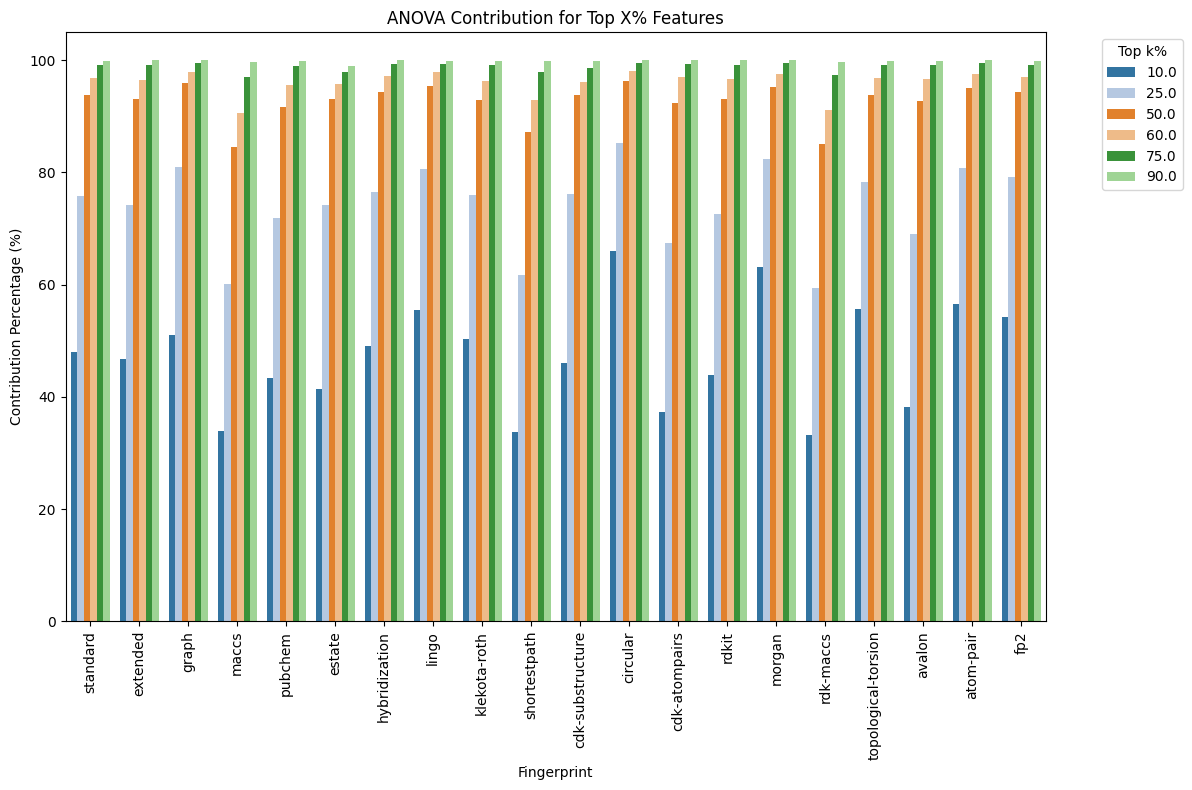

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the data for ANOVA: Select only the necessary columns
anova_df = summary_df[['Fingerprint', 'Top_k_Percentage', 'ANOVA_Contribution_Percentage']]

# Melt the DataFrame for ANOVA
anova_melted = anova_df.melt(id_vars=['Fingerprint', 'Top_k_Percentage'], value_vars=['ANOVA_Contribution_Percentage'], 
                             var_name='Score_Type', value_name='Contribution_Percentage')

# Set up the figure for ANOVA plot
plt.figure(figsize=(12, 8))

# Define a distinct color palette for Top_k_Percentage
palette = sns.color_palette("tab20", n_colors=len(summary_df['Top_k_Percentage'].unique()))

# Plot ANOVA contributions
sns.barplot(x='Fingerprint', y='Contribution_Percentage', hue='Top_k_Percentage', data=anova_melted, palette=palette, errorbar=None)

# Customize plot appearance
plt.title('ANOVA Contribution for Top X% Features')
plt.xlabel('Fingerprint')
plt.ylabel('Contribution Percentage (%)')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

# Display legend outside the plot
plt.legend(title='Top k%', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

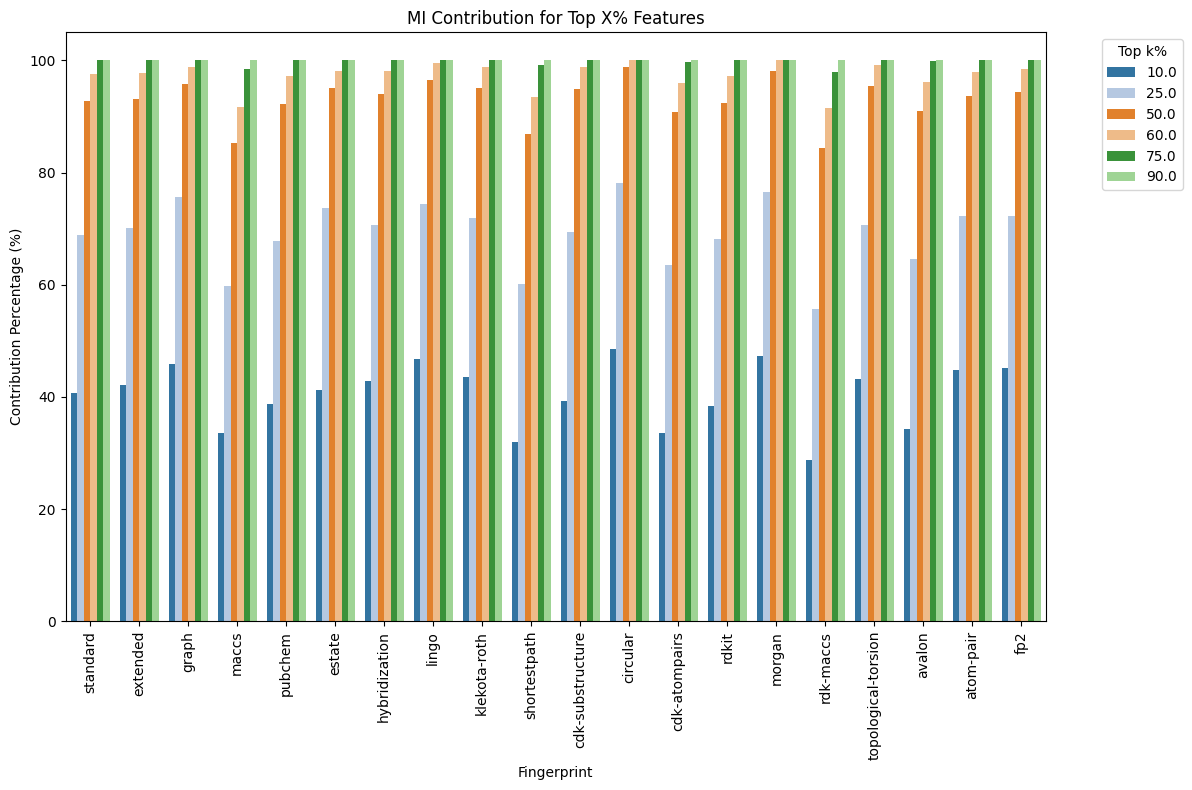

In [6]:
# Prepare the data for MI: Select only the necessary columns
mi_df = summary_df[['Fingerprint', 'Top_k_Percentage', 'MI_Contribution_Percentage']]

# Melt the DataFrame for MI
mi_melted = mi_df.melt(id_vars=['Fingerprint', 'Top_k_Percentage'], value_vars=['MI_Contribution_Percentage'], 
                       var_name='Score_Type', value_name='Contribution_Percentage')

# Set up the figure for MI plot
plt.figure(figsize=(12, 8))

# Plot MI contributions
sns.barplot(x='Fingerprint', y='Contribution_Percentage', hue='Top_k_Percentage', data=mi_melted, palette=palette, errorbar=None)

# Customize plot appearance
plt.title('MI Contribution for Top X% Features')
plt.xlabel('Fingerprint')
plt.ylabel('Contribution Percentage (%)')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

# Display legend outside the plot
plt.legend(title='Top k%', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

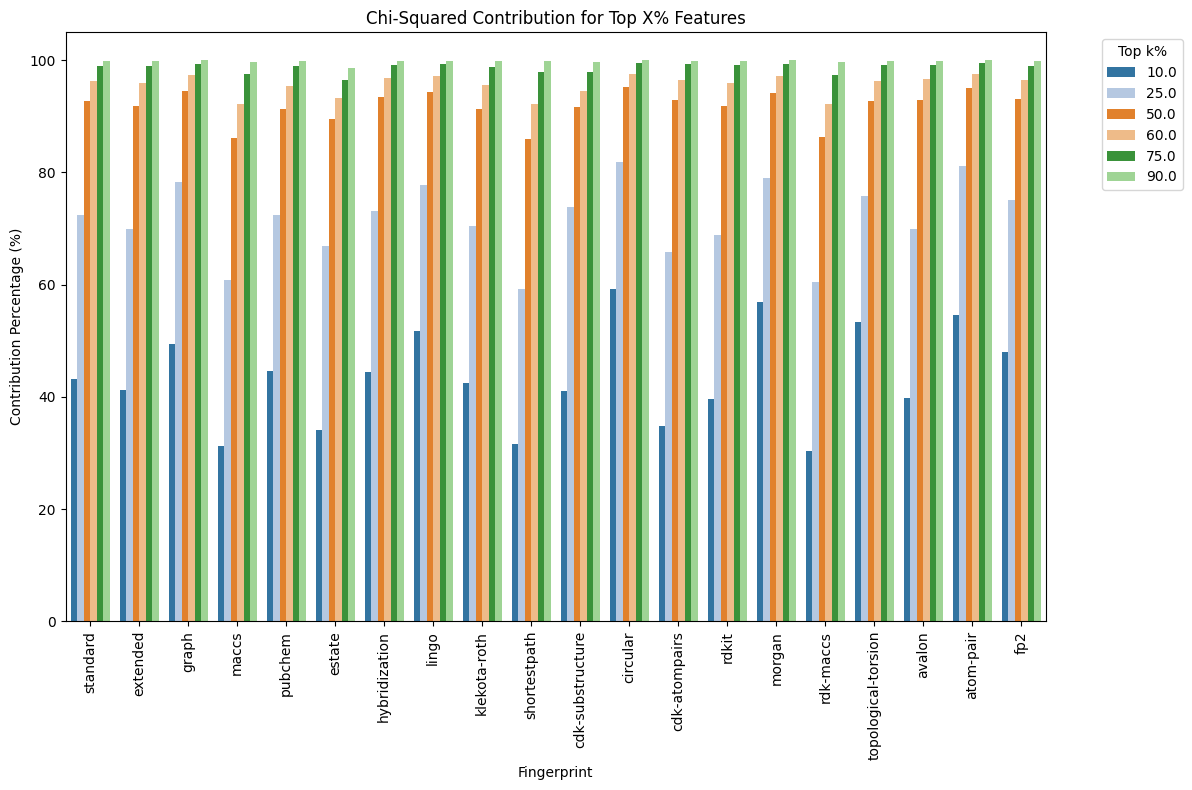

In [7]:
# Prepare the data for Chi2: Select only the necessary columns
chi2_df = summary_df[['Fingerprint', 'Top_k_Percentage', 'Chi2_Contribution_Percentage']]

# Melt the DataFrame for Chi2
chi2_melted = chi2_df.melt(id_vars=['Fingerprint', 'Top_k_Percentage'], value_vars=['Chi2_Contribution_Percentage'], 
                           var_name='Score_Type', value_name='Contribution_Percentage')

# Set up the figure for Chi2 plot
plt.figure(figsize=(12, 8))

# Plot Chi2 contributions
sns.barplot(x='Fingerprint', y='Contribution_Percentage', hue='Top_k_Percentage', data=chi2_melted, palette=palette, errorbar=None)

# Customize plot appearance
plt.title('Chi-Squared Contribution for Top X% Features')
plt.xlabel('Fingerprint')
plt.ylabel('Contribution Percentage (%)')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

# Display legend outside the plot
plt.legend(title='Top k%', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [8]:
# Group by Top_k_Percentage and calculate the average, max, and min for ANOVA, MI, and Chi-Squared contribution percentages
summary_stats = summary_df.groupby('Top_k_Percentage').agg(
    ANOVA_Avg=('ANOVA_Contribution_Percentage', 'mean'),
    ANOVA_Max=('ANOVA_Contribution_Percentage', 'max'),
    ANOVA_Min=('ANOVA_Contribution_Percentage', 'min'),
    MI_Avg=('MI_Contribution_Percentage', 'mean'),
    MI_Max=('MI_Contribution_Percentage', 'max'),
    MI_Min=('MI_Contribution_Percentage', 'min'),
    Chi2_Avg=('Chi2_Contribution_Percentage', 'mean'),
    Chi2_Max=('Chi2_Contribution_Percentage', 'max'),
    Chi2_Min=('Chi2_Contribution_Percentage', 'min')
).reset_index()

# Display the summary statistics
summary_stats

,Top_k_Percentage,ANOVA_Avg,ANOVA_Max,ANOVA_Min,MI_Avg,MI_Max,MI_Min,Chi2_Avg,Chi2_Max,Chi2_Min
0,10.0,47.369691,66.021679,33.183189,40.508503,48.456703,28.746219,43.590909,59.218013,30.388646
1,25.0,74.137078,85.270197,59.471393,69.204220,78.071689,55.621578,71.661850,81.840932,59.278498
2,50.0,92.692395,96.216122,84.522609,93.008537,98.805953,84.457053,91.869129,95.272596,85.943299
3,60.0,96.121052,98.059512,90.653079,97.335970,100.000000,91.434709,95.636533,97.571246,92.139159
4,75.0,98.908167,99.545811,97.091065,99.754594,100.000000,97.980688,98.727890,99.456556,96.482282
5,90.0,99.861914,99.973621,99.015585,100.000000,100.000000,100.000000,99.829673,99.970683,98.563306


In [9]:
# Filter the summary DataFrame to only include rows where Top_k_Percentage is 50%
summary_50_percent = summary_df[summary_df['Top_k_Percentage'] == 50.0]

# Select only the relevant columns: Fingerprint, ANOVA, MI, and Chi2 contributions
summary_50_percent = summary_50_percent[['Fingerprint', 'ANOVA_Contribution_Percentage', 
                                           'MI_Contribution_Percentage', 'Chi2_Contribution_Percentage']]

# Sort the DataFrame by Chi2_Contribution_Percentage in descending order
summary_50_percent_sorted = summary_50_percent.sort_values(by='Chi2_Contribution_Percentage', ascending=False)

# Display the sorted result
summary_50_percent_sorted

,Fingerprint,ANOVA_Contribution_Percentage,MI_Contribution_Percentage,Chi2_Contribution_Percentage
68,circular,96.216122,98.805953,95.272596
110,atom-pair,95.090546,93.725721,95.118710
14,graph,95.920651,95.722697,94.524122
44,lingo,95.460312,96.501095,94.395110
86,morgan,95.166764,98.091083,94.230089
38,hybridization,94.301980,93.923763,93.369433
116,fp2,94.379162,94.414294,93.140701
104,avalon,92.776616,90.955193,92.989321
74,cdk-atompairs,92.444643,90.758974,92.966605
98,topological-torsion,93.853872,95.383663,92.734643


In [10]:
# Filter the summary DataFrame to only include rows where Top_k_Percentage is 50%
summary_60_percent = summary_df[summary_df['Top_k_Percentage'] == 60.0]

# Select only the relevant columns: Fingerprint, ANOVA, MI, and Chi2 contributions
summary_60_percent = summary_60_percent[['Fingerprint', 'ANOVA_Contribution_Percentage', 
                                           'MI_Contribution_Percentage', 'Chi2_Contribution_Percentage']]

# Sort the DataFrame by Chi2_Contribution_Percentage in descending order
summary_60_percent_sorted = summary_60_percent.sort_values(by='Chi2_Contribution_Percentage', ascending=False)

# Display the sorted result
summary_60_percent_sorted

,Fingerprint,ANOVA_Contribution_Percentage,MI_Contribution_Percentage,Chi2_Contribution_Percentage
69,circular,98.059512,100.000000,97.571246
111,atom-pair,97.608642,97.930778,97.524980
15,graph,97.973143,98.895951,97.281308
45,lingo,97.823531,99.573891,97.262730
87,morgan,97.578415,99.998674,97.103643
39,hybridization,97.205765,98.185658,96.793722
105,avalon,96.587164,96.230489,96.593985
75,cdk-atompairs,97.063796,95.944188,96.519887
117,fp2,97.087898,98.509588,96.432452
3,standard,96.843682,97.512561,96.277692


In [11]:
# Filter the summary DataFrame to only include rows where Top_k_Percentage is 50%
summary_75_percent = summary_df[summary_df['Top_k_Percentage'] == 75.0]

# Select only the relevant columns: Fingerprint, ANOVA, MI, and Chi2 contributions
summary_75_percent = summary_75_percent[['Fingerprint', 'ANOVA_Contribution_Percentage', 
                                           'MI_Contribution_Percentage', 'Chi2_Contribution_Percentage']]

# Sort the DataFrame by Chi2_Contribution_Percentage in descending order
summary_75_percent_sorted = summary_75_percent.sort_values(by='Chi2_Contribution_Percentage', ascending=False)

# Display the sorted result
summary_75_percent_sorted

,Fingerprint,ANOVA_Contribution_Percentage,MI_Contribution_Percentage,Chi2_Contribution_Percentage
112,atom-pair,99.503071,100.000000,99.456556
70,circular,99.545811,100.000000,99.434114
16,graph,99.526619,100.000000,99.372339
88,morgan,99.444502,100.000000,99.337449
46,lingo,99.401175,100.000000,99.287216
76,cdk-atompairs,99.347140,99.623959,99.242761
40,hybridization,99.310165,100.000000,99.199608
100,topological-torsion,99.208720,100.000000,99.084578
106,avalon,99.214690,99.945513,99.068582
82,rdkit,99.238424,99.997057,99.067856
